In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [2]:
from recalibration import *
from utilities import *
# from model import *
from dataloader import *
from quantile_s2p import *
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
import random
from tueplots import bundles
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-04-13 13:37:42.226581: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
dict_bs_lr = {'air': (2048, 0.0001), 'refrigerator': (1024, 0.0001), 'furnace': (
    2048, 0.00001), 'dishwasher': (4096, 0.0001), 'clotheswasher': (2048, 0.0001)}
appliance = 'air'

In [4]:
def find_coverage_calib(y, y_upper_all, y_lower_all, ci, flag=False):
    q_hats = []
    times = []
    E_is = []
    random_seed = 42
    np.random.seed(random_seed)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_upper_all[i]
            initial_lower = y_lower_all[i]
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            E_i = E_i + np.random.normal(0, 1, len(E_i))

            E_is.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, E_is

In [5]:
def find_coverage_train_test(y, y_upper_all, y_lower_all, ci, q_hats, flag=False):
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_upper_all[i] + q_hats[i]
            lower = y_lower_all[i] - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

In [7]:
def get_trained_model(ci, x_train, y_train):
    alpha = 1 - ci
    lower_params_all = []
    upper_params_all = []
    lower_model_all = []
    upper_model_all = []
    for i in range(len(ci)):
        # define model
        lower_model = QuantileRegression(alpha=alpha[i]/2)
        upper_model = QuantileRegression(alpha=1 - alpha[i]/2)
        # initialize model and train
        lower_params = lower_model.init(jax.random.PRNGKey(0), x_train, True)
        # print(lower_params['params'].keys())
        lower_params, lower_losses = fit(lower_model, lower_params, x_train, y_train, False,
                                         batch_size=dict_bs_lr[f'{appliance}'][0], learning_rate=dict_bs_lr[f'{appliance}'][1], epochs=50)
        upper_params = upper_model.init(jax.random.PRNGKey(0), x_train, True)
        upper_params, upper_losses = fit(upper_model, upper_params, x_train, y_train, False,
                                         batch_size=dict_bs_lr[f'{appliance}'][0], learning_rate=dict_bs_lr[f'{appliance}'][1], epochs=50)
        lower_model_all.append(lower_model)
        upper_model_all.append(upper_model)
        lower_params_all.append(lower_params)
        upper_params_all.append(upper_params)
    return lower_params_all, upper_params_all, lower_model_all, upper_model_all

In [8]:
def get_all(ci, x, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler):
    lower_all = []
    upper_all = []
    for i in range(len(ci)):
        # get predictions x = {cal, test}
        y_hat_lower = lower_model_all[i].apply(lower_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        y_hat_upper = upper_model_all[i].apply(upper_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        mean_upper = scaler.inverse_transform(y_hat_upper)
        mean_lower = scaler.inverse_transform(y_hat_lower)
        lower_all.append(mean_lower)
        upper_all.append(mean_upper)
    return lower_all, upper_all

In [9]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [10]:
all = data_aggregated["dataid"].unique()

In [11]:
train_list = [[2361, 7719, 9019, 2335, 7951]]
cal_list = [[5746, 8565, 8156, 8386, 9160]]
test_list = [[4373, 7901, 3456, 3538, 2818]]

In [12]:
train_houses = train_list[0]
test_houses = test_list[0]
cal_houses = cal_list[0]
train = data_aggregated[data_aggregated["dataid"].isin(train_houses)]
test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]
cal = data_aggregated[data_aggregated["dataid"].isin(cal_houses)]

In [13]:
n = 99
x_train, y_train = dataloader(
    appliance, train, "2018-03-01 00:00:00-06", "2018-03-15 23:59:00-06", n)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)
x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
y_train = jnp.array(y_train)

In [14]:
x_test, y_test = dataloader(
    appliance, test, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_test = scaler_x.transform(x_test)
x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
y_test = jnp.array(y_test)

In [15]:
x_cal, y_cal = dataloader(
    appliance, cal, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_cal = scaler_x.transform(x_cal)
x_cal = jnp.array(x_cal).reshape(x_cal.shape[0], n, 1)
y_cal = jnp.array(y_cal)

In [16]:
# y_true_cal = scaler_y.inverse_transform(y_cal)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [17]:
ci = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [18]:
lower_params_all, upper_params_all, lower_model_all, upper_model_all = get_trained_model(
    ci, x_train, y_train)

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress:   0%|          | 0/1850 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress: 100%|██████████| 1850/1850 [00:15<00:00, 122.39epoch/s]


In [19]:
lower_train_all, upper_train_all = get_all(
    ci, x_train, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_test_all, upper_test_all = get_all(
    ci, x_test, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_cal_all, upper_cal_all = get_all(
    ci, x_cal, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)

In [20]:
initial_coverages_cal, _, _, _ = find_coverage_calib(
    y_cal, upper_cal_all, lower_cal_all, ci)
initial_coverages_train, _ = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, [])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, [])

In [21]:
initial_coverages_cal

array([0.        , 0.11303045, 0.1092187 , 0.30560085, 0.31798351,
       0.41365179, 0.50700659, 0.55455428, 0.54153264, 0.65363771,
       0.99969155])

In [22]:
initial_coverages_test

array([0.        , 0.08633105, 0.09424743, 0.20066735, 0.21874733,
       0.30638927, 0.37040126, 0.44500247, 0.49571833, 0.61414051,
       0.99727607])

In [23]:
initial_coverages_train

array([0.        , 0.11742823, 0.18592912, 0.31159954, 0.30958828,
       0.48529025, 0.65089652, 0.72399832, 0.84404249, 0.87524976,
       1.        ])

## After Calibration

In [24]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

## Conformal Prediction

Calibration dataset

In [25]:
flag = True
final_coverages_cal, q_hats, times, Errors_all_cal = find_coverage_calib(
    y_cal, upper_cal_all, lower_cal_all, ci, flag=flag)
final_coverages_train, q_hats = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, q_hats, flag=flag)
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, q_hats, flag=flag)

In [26]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 1.021354538202286 and ece error is 0.09285041256384417
Final ace error is 0.7451636735349894 and ece error is 0.06774215213954449


In [27]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.29190766642128524 and ece error is 0.026537060583753203
Final ace error is 1.8333210642549163 and ece error is 0.16666555129590147


In [28]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)
print('Test:')
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Test:
Initial ace error is 1.6710789203643799 and ece error is 0.1519162654876709
Final ace error is 0.6445478537119924 and ece error is 0.058595259428362946


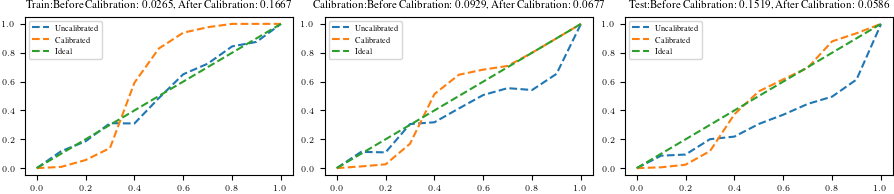

In [29]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')